In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [4]:
passengers = pd.read_csv('air_passengers.csv', index_col='Month')
passengers.index = pd.to_datetime(passengers.index, format = '%Y-%m')
passengers.head()

,count
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
split_ratio = .75
split_point = int(round(len(passengers) * split_ratio))
train, test = passengers.iloc[:split_point,:], passengers.iloc[split_point:,:]

In [6]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [7]:
X_tr_sc = train_scaled[:-1]
y_tr_sc = train_scaled[1:]
X_tst_sc = test_scaled[:-1]
y_tst_sc = test_scaled[1:]

In [15]:
X_tr_sc.shape

(107, 1)

In [16]:
X_tr_sc = X_tr_sc.reshape(X_tr_sc.shape[0], 1, X_tr_sc.shape[1])
X_tst_sc = X_tst_sc.reshape(X_tst_sc.shape[0], 1, X_tst_sc.shape[1])

In [17]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_tr_sc.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_sc, y_tr_sc, epochs=50, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

test_pred_sc = model_lstm.predict(X_tst_sc)
train_pred_sc = model_lstm.predict(X_tr_sc)

print("R2 score on the Train set:\t{:0.3f}".format(r2_score(y_tr_sc, train_pred_sc)))
r2_train = r2_score(y_tr_sc, train_pred_sc)

print("Adjusted R2 score on the Train set:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_tr_sc.shape[0], X_tr_sc.shape[1])))

print("R2 score on the Test set:\t{:0.3f}".format(r2_score(y_tst_sc, test_pred_sc)))
r2_test = r2_score(y_tst_sc, test_pred_sc)

print("Adjusted R2 score on the Test set:\t{:0.3f}".format(adj_r2_score(r2_test, X_tst_sc.shape[0], X_tst_sc.shape[1])))


Epoch 1/50
107/107 [==============================] - 4s 36ms/step - loss: 0.0261
Epoch 2/50
107/107 [==============================] - 1s 5ms/step - loss: 0.0178
Epoch 3/50
107/107 [==============================] - 1s 5ms/step - loss: 0.0163
Epoch 4/50
107/107 [==============================] - 1s 5ms/step - loss: 0.0138
Epoch 5/50
107/107 [==============================] - 1s 5ms/step - loss: 0.0115
Epoch 6/50
107/107 [==============================] - 1s 5ms/step - loss: 0.0095
Epoch 7/50
107/107 [==============================] - 1s 5ms/step - loss: 0.0080
Epoch 8/50
107/107 [==============================] - 1s 5ms/step - loss: 0.0069
Epoch 9/50
107/107 [==============================] - 1s 6ms/step - loss: 0.0061
Epoch 10/50
107/107 [==============================] - 1s 6ms/step - loss: 0.0056
Epoch 11/50
107/107 [==============================] - 1s 6ms/step - loss: 0.0053
Epoch 12/50
107/107 [==============================] - 1s 6ms/step - loss: 0.0052
Epoch 13/50
107/107 [===

In [18]:
model_lstm.save('LSTM_NonShift.h5')

In [19]:
score_lstm= model_lstm.evaluate(X_tst_sc, y_tst_sc, batch_size=1)

35/35 [==============================] - 0s 4ms/step


In [20]:
print('LSTM: %f'%score_lstm)

LSTM: 0.018773


In [21]:
test_pred_sc = model_lstm.predict(X_tst_sc)

In [ ]:
plt.plot(y_tst_sc, label='Actual')
plt.plot(test_pred_sc, label='Predicted')
plt.title("LSTM's_Prediction (scaled)")
plt.xlabel('Observation')
plt.ylabel('Scaled values')
plt.legend()
plt.show()

In [21]:
test_pred = scaler.inverse_transform(test_pred_sc)
y_test = test[1:]

In [23]:
test_pred = test_pred.ravel()

In [24]:
test_pred = pd.Series(test_pred)

In [25]:
test_pred.index = test.index[1:]

Text(0.5,1,'RMSE: 51.1164')

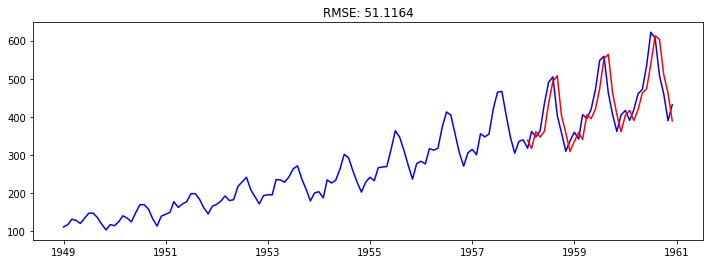

In [45]:
plt.figure(figsize=(12, 4))
plt.plot(passengers, 'b')
plt.plot(test_pred, 'r')

plt.title('RMSE: %.4f'% np.sqrt(sum((test_pred.values - y_test['count'].values)**2)/len(y_test)))


In [36]:
test_pred.values

array([339.16614, 317.3619 , 361.20963, 347.15598, 362.2168 , 435.66125,
       493.5893 , 508.1115 , 403.84122, 358.19083, 309.49872, 336.17804,
       359.1967 , 341.1607 , 405.8863 , 395.673  , 420.23392, 473.89465,
       552.6771 , 564.04803, 464.5765 , 406.9093 , 361.20963, 404.86362,
       417.1549 , 390.57837, 419.2073 , 462.50723, 473.89465, 539.2185 ,
       613.0009 , 603.1082 , 511.2237 , 462.50723, 389.56052],
      dtype=float32)

In [42]:
y_test['count'].values

array([318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337, 360, 342,
       406, 396, 420, 472, 548, 559, 463, 407, 362, 405, 417, 391, 419,
       461, 472, 535, 622, 606, 508, 461, 390, 432])

In [34]:
len(test_pred.values -y_test.values)

35

In [43]:
sum((test_pred.values - y_test['count'].values)**2)

91451.03758816328

51.11640429679338

In [29]:
y_test.head()

,count
Month,
1958-02-01,318
1958-03-01,362
1958-04-01,348
1958-05-01,363
1958-06-01,435


In [28]:
test_pred.head()

Month
1958-02-01    339.166138
1958-03-01    317.361908
1958-04-01    361.209625
1958-05-01    347.155975
1958-06-01    362.216797
dtype: float32

In [29]:
test[1:]

,count
Month,
1958-02-01,318
1958-03-01,362
1958-04-01,348
1958-05-01,363
1958-06-01,435
1958-07-01,491
1958-08-01,505
1958-09-01,404
1958-10-01,359
